# Experiments to find which binary models perform best

In [1]:
import time
import os
import glob
import re
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product

# import ray

from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

In [2]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams.update({'font.size': 12})

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
run_experiments = False

In [5]:
incerto_dir = '/content/drive/MyDrive/incerto-autore'
figures_dir = os.path.join(incerto_dir, 'figures')
output_dir = os.path.join(incerto_dir, 'output')
performance_dir = os.path.join(incerto_dir, 'output','classification-performance')

## Set up

In [ ]:
scalers = {'StandardScaler': StandardScaler(),
           'L1': Normalizer(norm='l1'),
           'L2': Normalizer(norm='l2')}

In [ ]:
def build_vectorizer(_typ, _ngram, _max, _min, _max_f):

    if _max_f == 'None':
        _max_f = None

    if _typ == 'Count':
        vec = CountVectorizer(input='content',
                    encoding='utf-8',
                    lowercase=True,
                    analyzer=_ngram[0].lower(),
                    ngram_range=_ngram[2],
                    max_df=_max,
                    min_df=_min,
                    max_features=_max_f)

    elif _typ == 'TfIdf':
        vec = TfidfVectorizer(input='content',
                    encoding='utf-8',
                    lowercase=True,
                    analyzer=_ngram[0].lower(),
                    ngram_range=_ngram[2],
                    max_df=_max,
                    min_df=_min,
                    max_features=_max_f,
                    norm=None)
    return vec

In [ ]:
matrix_options = {'vectorizer':['Count', 'TfIdf'],
           'ngram': [['Char','Bigrams', (2,2)],['Char','Trigrams', (3,3)],['Word','Unigrams', (1,1)]],
           'max_df': [0.8,0.9,1.0],
           'min_df': [0.0,0.1,0.2],
           'max_f': ['None', 1000],
           'scaler': scalers.keys()}

In [ ]:
total = matrix_options.values()
matrix_combos = list(product(*total))
print(len(matrix_combos))
matrix_combos[0]

324


('Count', ['Char', 'Bigrams', (2, 2)], 0.8, 0.0, 'None', 'StandardScaler')

In [ ]:
classifiers = {
  'RandomForest': RandomForestClassifier(),
  'kNN': KNeighborsClassifier(),
  'Logit': LogisticRegression(),
  'SVM': SVC()}

## Experiments

In [ ]:
if run_experiments == True:
    ray.init(num_cpus=6)

In [ ]:
@ray.remote
def do_classification(_combo, _scaled_X, _golden_labels, _classifiers, _classifier, _author, _num_f, _typ, _path):

    scores = cross_validate( # perform cross-validation
            _classifiers[_classifier], # classifier object
            _scaled_X, # feature matrix
            _golden_labels, # gold labels
            cv=3, #number of folds
            scoring=['f1_macro']) # scoring methods
    scores_df = pd.DataFrame(scores).mean()

    with open(_path, 'a') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow((_classifier, _author, _combo[0],
                            _combo[1][0], _combo[1][1],
                            _combo[2], _combo[3], _combo[4], _num_f,
                            _combo[5], scores_df.loc['test_f1_macro'], _typ))

In [ ]:
# 8 is the number of authors we are training on and 2 is the number of poem types
len(matrix_combos)*len(classifiers.keys())*8*2

In [ ]:
classification_path = os.path.join(output_dir, f'binary_classification_performance.csv')
if not os.path.exists(classification_path):
    with open(classification_path, 'w') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(('classifier', 'author', 'vectorizer',
                            'ngram type', 'ngram range',
                            'max_df', 'min_df', 'max_f', 'num_f',
                            'scaler', 'f1-score', 'type'))

In [ ]:
if run_experiments == True:

    for typ in ['Split', 'Whole']:

        poems_path = os.path.join(incerto_dir, 'data', 'poems', f'poems_{typ.lower()}.csv')
        all_poems_df = pd.read_csv(poems_path)
        print(f'All {typ} poems:\t', len(all_poems_df))
        poems_df = all_poems_df.loc[all_poems_df['author'] != 'Unknown']
        print(f'Known {typ} poems:\t', len(poems_df))

        for combo in matrix_combos:

            if combo[1][0] == 'Char':
                poems = [re.sub(r'\s+', '', x) for x in poems_df['poem'].tolist()]
            elif combo[1][0] == 'Word':
                poems = poems_df['poem'].tolist()
            vectorizer = build_vectorizer(combo[0], combo[1], combo[2], combo[3], combo[4])

            X = vectorizer.fit_transform(poems)
            num_f = X.shape[1]
            scaled_X = scalers[combo[5]].fit_transform(X.toarray())

            for author in poems_df['author'].unique():

                futures = []

                golden_labels = poems_df['author'].map(lambda x: 1 if x==author else 0).tolist()

                for classifier in classifiers.keys():

                    #do_classification(combo, scaled_X, golden_labels, classifiers, classifier, author, num_f, path)

                    futures.append(do_classification.remote(combo, scaled_X, golden_labels, classifiers, classifier, author, num_f, typ, classification_path))

                results = ray.get(futures)

## Evaluating overall performance

In [6]:
performance_path = os.path.join(performance_dir, f'binary_classification_performance.csv')
results_df = pd.read_csv(performance_path)
print(len(results_df))
results_df.head()

20736


,classifier,author,vectorizer,ngram type,ngram range,max_df,min_df,max_f,num_f,scaler,f1-score,type
0,kNN,Franco,Count,Char,Bigrams,0.8,0.0,None,243,StandardScaler,0.579222,Split
1,Logit,Franco,Count,Char,Bigrams,0.8,0.0,None,243,StandardScaler,0.695865,Split
2,SVM,Franco,Count,Char,Bigrams,0.8,0.0,None,243,StandardScaler,0.708432,Split
3,RandomForest,Franco,Count,Char,Bigrams,0.8,0.0,None,243,StandardScaler,0.597630,Split
4,kNN,AntonGiacomoCorso,Count,Char,Bigrams,0.8,0.0,None,243,StandardScaler,0.529948,Split


In [ ]:
for author in results_df.author.unique():
  av = results_df.loc[results_df['author'] == author][['f1-score']].mean()
  print(author, av)

Franco f1-score    0.603557
dtype: float64
AntonGiacomoCorso f1-score    0.494098
dtype: float64
PietroBembo f1-score    0.49977
dtype: float64
CelioMagno f1-score    0.483307
dtype: float64
DomenicoVenier f1-score    0.485428
dtype: float64
GiorgioGradenigo f1-score    0.494793
dtype: float64
MarcoVenier f1-score    0.495645
dtype: float64
Petrarca f1-score    0.566007
dtype: float64


In [7]:
baselines = pd.read_csv(os.path.join(performance_dir, 'binary_baseline.csv'))
baselines

,Author,Poem format,Naive Classifier Type,F-1 score
0,AntonGiacomoCorso,Split,Majority,0.475105
1,AntonGiacomoCorso,Whole,Majority,0.476340
2,CelioMagno,Split,Majority,0.475990
3,CelioMagno,Whole,Majority,0.471337
4,DomenicoVenier,Split,Majority,0.483389
5,DomenicoVenier,Whole,Majority,0.468799
6,Franco,Split,Majority,0.390195
7,Franco,Whole,Majority,0.484474
8,GiorgioGradenigo,Split,Majority,0.494720
9,GiorgioGradenigo,Whole,Majority,0.490015


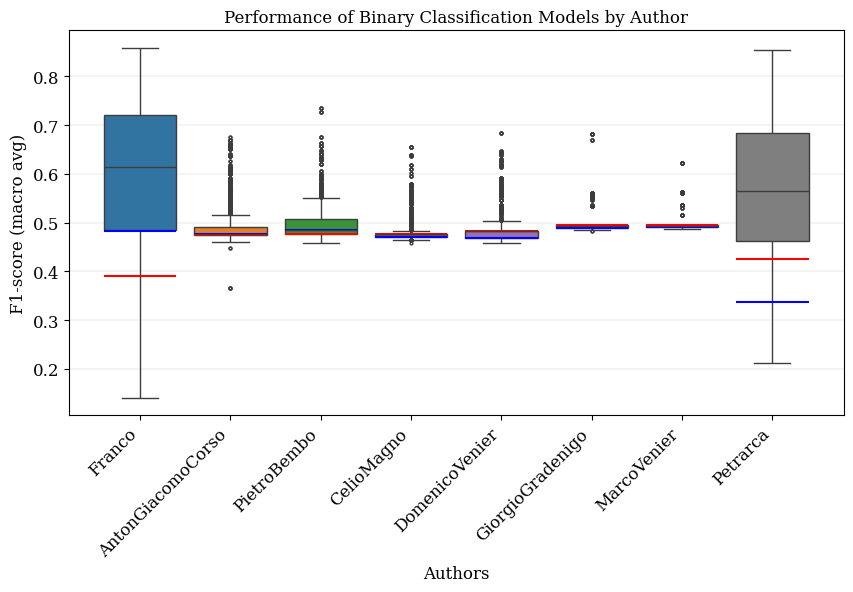

In [12]:
plt.figure(figsize=(10, 5))
ax = sns.boxplot(x='author', y='f1-score', data=results_df, hue='author',
                 fliersize=2)
ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)

for typ, clr in {'Whole': 'blue', 'Split': 'red'}.items():
  tick = 0
  for author in results_df.author.unique():
    baseline = baselines[(baselines['Author'] == author) & (baselines['Poem format'] == typ)]['F-1 score'].values[0]
    if author=='Franco' and typ=='Whole':
      baseline -= 0.001
    xmin = tick -0.4
    xmax = tick +0.4
    ax.hlines(baseline, xmin, xmax, color=clr)
    tick += 1

plt.xticks(rotation=45, ha='right')
plt.title('Performance of Binary Classification Models by Author', size=12)
plt.ylabel('F1-score (macro avg)')
plt.xlabel('Authors')
plt.savefig(os.path.join(figures_dir, f'performance.png'), dpi = 300, bbox_inches = "tight")
plt.show()

In [ ]:
def make_figure(hue_label):

    plt.figure(figsize=(15, 5))
    ax = sns.boxplot(x='author', y='f1-score', data=results_df, hue=hue_label.lower())
    ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
    plt.xlabel(hue_label)
    plt.ylabel('F1-score (macro avg)')
    plt.title(f'Performance of different {hue_label.lower()}s')
    plt.show()

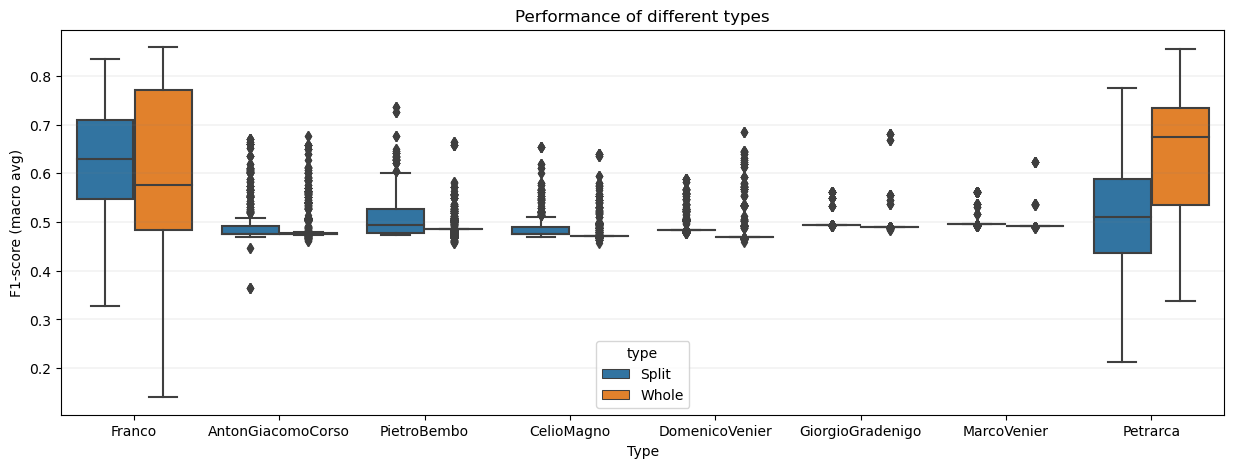

In [ ]:
make_figure('Type')

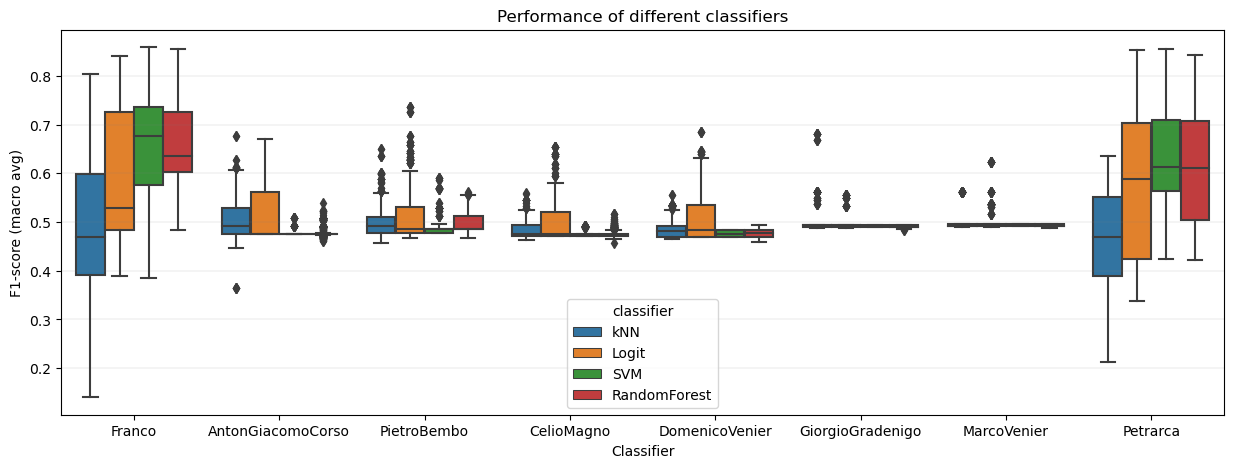

In [ ]:
make_figure('Classifier')

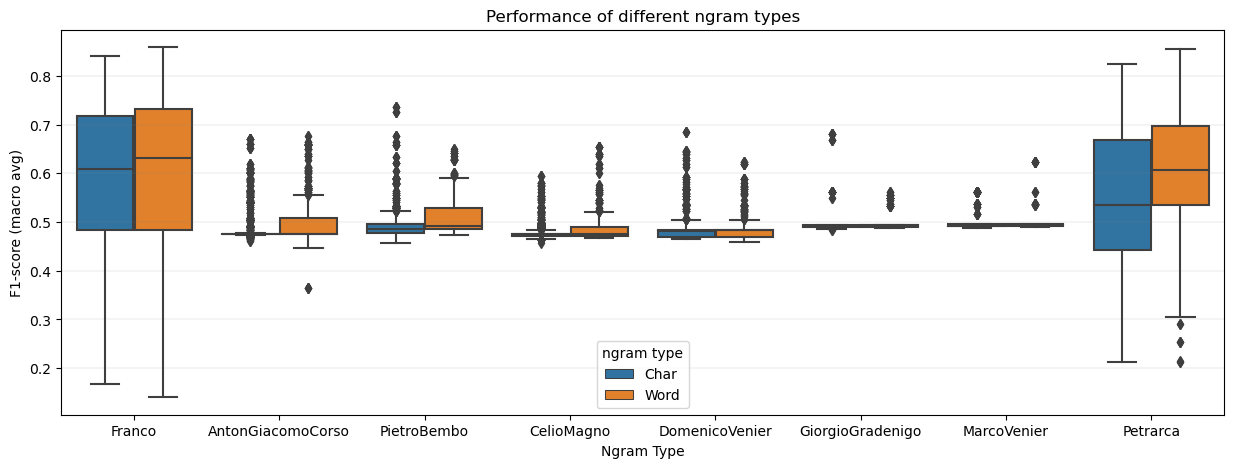

In [ ]:
make_figure('Ngram Type')

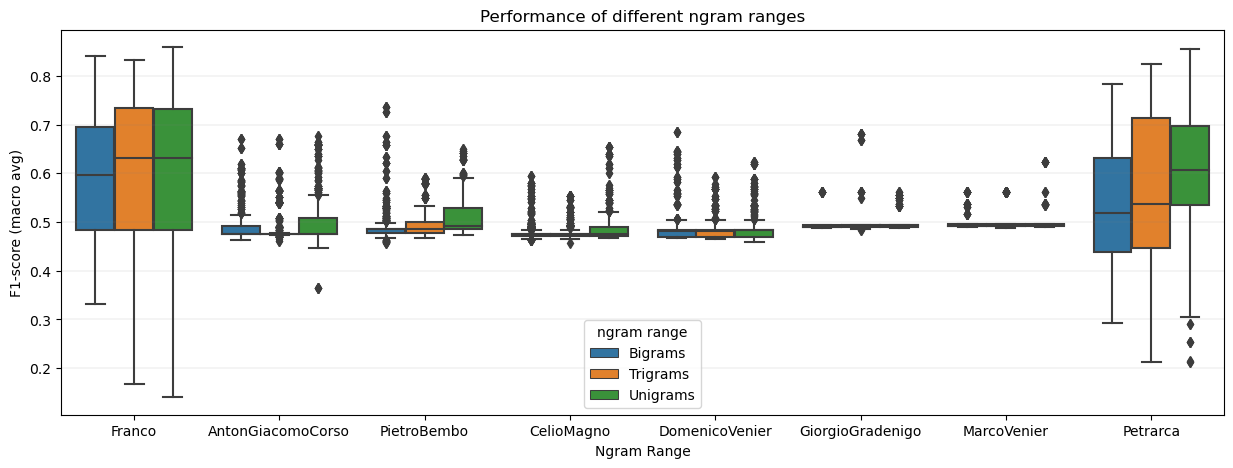

In [ ]:
make_figure('Ngram Range')

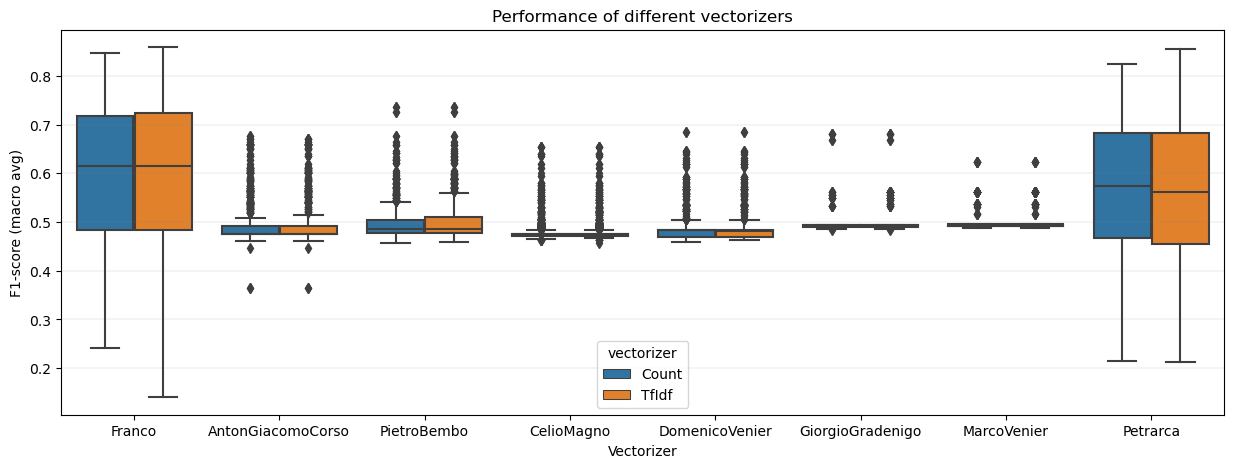

In [ ]:
make_figure('Vectorizer')

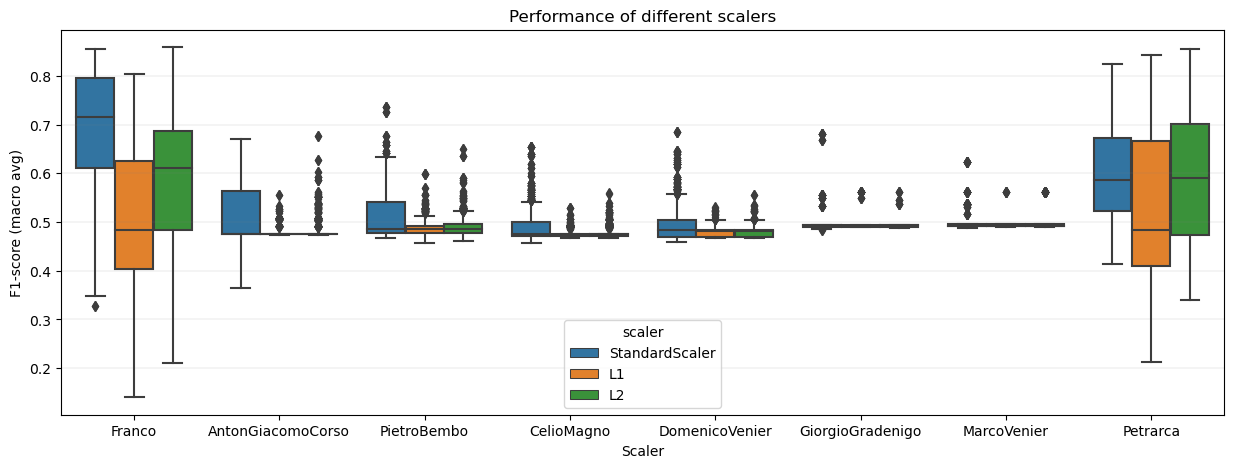

In [ ]:
make_figure('Scaler')